In [18]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.safari.options import Options
import pandas as pd


options = Options()
options.headless = True
driver = webdriver.Safari(options=options)

base_urls = {year: f'https://www.worldsurfleague.com/athletes/tour/mct?year={year}' for year in range(2010, 2025)}

def scrape_data(url, year):
    driver.get(url)
    results = []

    try:
        headers = driver.find_elements(By.CSS_SELECTOR, 'table thead th')
        columns = []
        for header in headers:
            header_text = header.text.strip()
            if header.text.strip() != '' and header.text.strip() != 'Points from each tour event' and header.text.strip() != 'WSL Finals' and header.text.strip() != 'In Progress' and header.text.strip() != '(Live)':
                if 'athlete-event-place' in header.get_attribute('class'):
                    tooltip = header.find_element(By.CSS_SELECTOR, 'span.tooltip-item')
                    competition_name = tooltip.get_attribute('data-tooltip').split('>')[1].split('<')[0]
                    if(year <= 2022):
                        competition_name = tooltip.get_attribute('data-tooltip').split('>')[2].split('<')[0]

                    columns.append(competition_name)
                else:
                    columns.append(header_text)

        print(f"Year {year} - Columns: {columns}")

        rows = driver.find_elements(By.CSS_SELECTOR, 'table tbody tr')
        # olympics = False
        count = 1
        for row in rows:
            if 'insertedathlete-553 mid-cut-off-row' in row.get_attribute('class') or 'insertedathlete-3442 cut-off-row tour-mct' in row.get_attribute('class'):
                continue

            cells = row.find_elements(By.CSS_SELECTOR, 'td')
            filtered_cells = []


            # for cell in cells:
            #     a = cell.find_elements(By.CSS_SELECTOR, 'span.athlete-qualified-frame')
            #     if a:# or cell.find_elements(By.CSS_SELECTOR, 'div.athlete-flags-frame span.athlete-qualified-frame.athlete-qualified'):
            #         olympics = True
            #         # print(count)
            #         # count= count+1
            #         break

            # if(olympics == False):
            #     continue


            for i, cell in enumerate(cells):
                if (cell.text.strip() == '' or cell.text.strip() == '-') and i < 6:
                    continue
                if 'athlete-rank-change' in cell.get_attribute('class'):
                    continue
                if 'athlete-finalist' in cell.get_attribute('class'):
                    continue
                # if cell.find_elements(By.CSS_SELECTOR, 'div.athlete-flags-wildcardframe span.athlete-qualified-frame.athlete-qualified') or cell.find_elements(By.CSS_SELECTOR, 'div.athlete-flags-frame span.athlete-qualified-frame.athlete-qualified'):
                #     continue
                # print (cell.text.strip())
                filtered_cells.append(cell)
                # print(f"Cell: {cell.text}")
            # filtered_cells = [cell for i, cell in enumerate(cells) if i < 6 and cell.text.strip() != '' and cell.text.strip() != '-']


            print(f"Cells found: {len(filtered_cells)}")



            if len(filtered_cells) == len(columns):
                data = {
                    "Rank": None,
                    "Name": None,
                    "Events": {},
                    "Total Points": None,
                    "Year": year
                }
                for i, cell in enumerate(filtered_cells):
                    if 'Rank' in columns[i]:
                        data['Rank'] = cell.text
                    elif 'Name' in columns[i]:
                        try:
                            name_link = cell.find_element(By.CSS_SELECTOR, 'a.athlete-name')
                            data['Name'] = name_link.text
                        except Exception as e:
                            print(f"Error extracting name: {e}")
                            data['Name'] = cell.text
                    elif 'Total Points' in columns[i]:
                        try:
                            points_span = cell.find_element(By.CSS_SELECTOR, 'span.tour-points')
                            data['Total Points'] = points_span.text
                        except:
                            data['Total Points'] = cell.text

                    elif 'Live Total Points' in columns[i]:
                        try:
                            points_span = cell.find_element(By.CSS_SELECTOR, 'span.tour-points')
                            data['Total Points'] = points_span.text
                        except:
                            data['Total Points'] = cell.text

                    else:
                        try:
                            tooltip_item = cell.find_element(By.CSS_SELECTOR, 'span.tooltip-item')
                            data['Events'][columns[i]] = tooltip_item.text
                        except:
                            data['Events'][columns[i]] = cell.text


                results.append(data)
                print(f"Data row: {data}")


            olympics = False


    except Exception as e:
        print(f"Error al extraer datos de {url}: {e}")

    return results

all_data = []
for year, base_url in base_urls.items():
    try:
        data = scrape_data(base_url, year)
        all_data.extend(data)
    except Exception as e:
        print(f"Error scraping {base_url}: {e}")

df_data = []

for item in all_data:
    row = {
        "Rank": item["Rank"],
        "Name": item["Name"],
        "Total Points": item["Total Points"]
    }
    row.update(item["Events"])
    df_data.append(row)

df = pd.DataFrame(df_data)

df.to_csv('world_surf_league.csv', index=False)

print('Extracción de datos completada y guardada en world_surf_league.csv.')

driver.quit()


Year 2010 - Columns: ['Rank', 'Name', 'Quiksilver Pro Gold Coast', 'Rip Curl Pro Bells Beach', 'Santa Catarina Pro', 'Billabong Pro J-Bay', 'Billabong Pro Teahupoo', 'Hurley Pro Trestles', 'Quiksilver Pro France', 'Rip Curl Pro Portugal', 'Rip Curl Search', 'Billabong Pipe Masters', 'Total Points']
Cells found: 13
Data row: {'Rank': '1', 'Name': 'Kelly Slater', 'Events': {'Quiksilver Pro Gold Coast': '3,750', 'Rip Curl Pro Bells Beach': '10,000', 'Santa Catarina Pro': '8,000', 'Billabong Pro J-Bay': '1,750', 'Billabong Pro Teahupoo': '6,500', 'Hurley Pro Trestles': '10,000', 'Quiksilver Pro France': '8,000', 'Rip Curl Pro Portugal': '10,000', 'Rip Curl Search': '10,000', 'Billabong Pipe Masters': '6,500'}, 'Total Points': '69,000', 'Year': 2010}
Cells found: 13
Data row: {'Rank': '2', 'Name': 'Jordy Smith', 'Events': {'Quiksilver Pro Gold Coast': '8,000', 'Rip Curl Pro Bells Beach': '5,250', 'Santa Catarina Pro': '5,250', 'Billabong Pro J-Bay': '10,000', 'Billabong Pro Teahupoo': '1,75

In [24]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.safari.options import Options
import pandas as pd


options = Options()
options.headless = True
driver = webdriver.Safari(options=options)


base_urls = {year: f'https://www.worldsurfleague.com/athletes/tour/mct?year={year}' for year in range(2010, 2025)}


In [29]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ipdb
import json

data_by_year = {}

for year, base_url in base_urls.items():
    try:
        data = scrape_data(base_url, year)
        data_by_year[year] = data
    except Exception as e:
        print(f"Error scraping {base_url}: {e}")

json_data = json.dumps(data_by_year, indent=4)

with open('surf_data_by_year.json', 'w') as f:
    f.write(json_data)

Year 2010 - Columns: ['Rank', 'Name', 'Quiksilver Pro Gold Coast', 'Rip Curl Pro Bells Beach', 'Santa Catarina Pro', 'Billabong Pro J-Bay', 'Billabong Pro Teahupoo', 'Hurley Pro Trestles', 'Quiksilver Pro France', 'Rip Curl Pro Portugal', 'Rip Curl Search', 'Billabong Pipe Masters', 'Total Points']
Cells found: 13
Data row: {'Rank': '1', 'Name': 'Kelly Slater', 'Events': {'Quiksilver Pro Gold Coast': '3,750', 'Rip Curl Pro Bells Beach': '10,000', 'Santa Catarina Pro': '8,000', 'Billabong Pro J-Bay': '1,750', 'Billabong Pro Teahupoo': '6,500', 'Hurley Pro Trestles': '10,000', 'Quiksilver Pro France': '8,000', 'Rip Curl Pro Portugal': '10,000', 'Rip Curl Search': '10,000', 'Billabong Pipe Masters': '6,500'}, 'Total Points': '69,000', 'Year': 2010}
Cells found: 13
Data row: {'Rank': '2', 'Name': 'Jordy Smith', 'Events': {'Quiksilver Pro Gold Coast': '8,000', 'Rip Curl Pro Bells Beach': '5,250', 'Santa Catarina Pro': '5,250', 'Billabong Pro J-Bay': '10,000', 'Billabong Pro Teahupoo': '1,75

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ipdb
import json

In [4]:
with open('surf_data_by_year.json', 'r') as file:
    json_data_to_df = json.load(file)


all_data = []
for year, records in json_data_to_df.items():
    for record in records:
        event_data = record.pop('Events')
        flat_record = {**record, **event_data}
        all_data.append(flat_record)

df = pd.DataFrame(all_data)
print(df)

    Rank           Name Total Points  Year Quiksilver Pro Gold Coast  \
0      1   Kelly Slater       69,000  2010                     3,750   
1      2    Jordy Smith       52,250  2010                     8,000   
2      3   Mick Fanning       44,750  2010                     3,750   
3      4  Dane Reynolds       42,000  2010                     6,500   
4      4     Taj Burrow       42,000  2010                    10,000   
..   ...            ...          ...   ...                       ...   
533   30  Callum Robson        6,245  2024                       NaN   
534   31   Kelly Slater        5,320  2024                       NaN   
535   32   Eli Hanneman        5,320  2024                       NaN   
536   33   Deivid Silva        5,320  2024                       NaN   
537   34   Joao Chianca        1,060  2024                       NaN   

    Rip Curl Pro Bells Beach Santa Catarina Pro Billabong Pro J-Bay  \
0                     10,000              8,000               1,

In [4]:
df = pd.DataFrame(all_data)
print(df)

    Rank           Name Total Points  Year Quiksilver Pro Gold Coast  \
0      1   Kelly Slater       69,000  2010                     3,750   
1      2    Jordy Smith       52,250  2010                     8,000   
2      3   Mick Fanning       44,750  2010                     3,750   
3      4  Dane Reynolds       42,000  2010                     6,500   
4      4     Taj Burrow       42,000  2010                    10,000   
..   ...            ...          ...   ...                       ...   
533   30  Callum Robson        6,245  2024                       NaN   
534   31   Kelly Slater        5,320  2024                       NaN   
535   32   Eli Hanneman        5,320  2024                       NaN   
536   33   Deivid Silva        5,320  2024                       NaN   
537   34   Joao Chianca        1,060  2024                       NaN   

    Rip Curl Pro Bells Beach Santa Catarina Pro Billabong Pro J-Bay  \
0                     10,000              8,000               1,

In [5]:



nombres_a_filtrar=['Gabriel Medina',
'Ramzi Boukhiam',
'Kauli Vaast',
'Joan Duru',
'Alonso Correa',
'Andy Criere',
'Rio Waida',
'Ethan Ewing',
'Tim Elter',
'Leonardo Fioravanti',
'John John Florence',
'Filipe Toledo',
'Jack Robinson',
'Lucca Mesinas',
'Billy Stairmand',
'Connor O ́Leary',
'Jordy Smith',
'Reo Inaba',
'Alan Cleland',
'Kanoa Igarashi',
'Matthew McGillivray',
'Griffin Colapinto',
'João Chianca']


df = df[df['Name'].isin(nombres_a_filtrar)]


print(df.drop_duplicates(subset=['Name']))


    Rank                 Name Total Points  Year Quiksilver Pro Gold Coast  \
1      2          Jordy Smith       52,250  2010                     8,000   
82     4   John John Florence       44,350  2012                     1,750   
85     7       Gabriel Medina       41,350  2012                       500   
127   15        Filipe Toledo       24,400  2013                     1,750   
234   20       Kanoa Igarashi       24,250  2016                     4,000   
272   21            Joan Duru       23,400  2017                       500   
278   26  Leonardo Fioravanti       18,700  2017                       500   
285   34          Ethan Ewing       10,750  2017                       500   
303   18    Griffin Colapinto       23,275  2018                     6,085   
383   24  Matthew McGillivray            0  2020                       NaN   
384   25        Jack Robinson            0  2020                       NaN   
455   25        Lucca Mesinas        8,735  2022                

In [6]:
df_unique = df.drop_duplicates(subset='Name', keep='first')

print(df_unique)

df_unique.to_csv('unique_world_surf_league.csv', index=False)

    Rank                 Name Total Points  Year Quiksilver Pro Gold Coast  \
1      2          Jordy Smith       52,250  2010                     8,000   
82     4   John John Florence       44,350  2012                     1,750   
85     7       Gabriel Medina       41,350  2012                       500   
127   15        Filipe Toledo       24,400  2013                     1,750   
234   20       Kanoa Igarashi       24,250  2016                     4,000   
272   21            Joan Duru       23,400  2017                       500   
278   26  Leonardo Fioravanti       18,700  2017                       500   
285   34          Ethan Ewing       10,750  2017                       500   
303   18    Griffin Colapinto       23,275  2018                     6,085   
383   24  Matthew McGillivray            0  2020                       NaN   
384   25        Jack Robinson            0  2020                       NaN   
455   25        Lucca Mesinas        8,735  2022                

In [6]:
df['Total Points'] = df['Total Points'].str.replace(',', '').astype(float)

In [7]:
df['SHISEIDO Tahiti Pro'] = df['SHISEIDO Tahiti Pro'].str.replace('*', '')
df['SHISEIDO Tahiti Pro presented by Outerknown'] = df['SHISEIDO Tahiti Pro presented by Outerknown'].str.replace('*', '')

In [8]:
df['SHISEIDO Tahiti Pro'] = df['SHISEIDO Tahiti Pro'].str.replace('-', '0')
df['SHISEIDO Tahiti Pro presented by Outerknown'] = df['SHISEIDO Tahiti Pro presented by Outerknown'].str.replace('-', '0')


In [9]:

df['SHISEIDO Tahiti Pro'] = df['SHISEIDO Tahiti Pro'].str.replace(',', '').astype(float)
df['SHISEIDO Tahiti Pro presented by Outerknown'] = df['SHISEIDO Tahiti Pro presented by Outerknown'].str.replace(',', '').astype(float)


In [10]:
print(df.loc[df['Year'] == 2024])

    Rank                 Name  Total Points  Year Quiksilver Pro Gold Coast  \
504    1   John John Florence       31465.0  2024                       NaN   
505    2    Griffin Colapinto       27195.0  2024                       NaN   
506    3        Jack Robinson       25980.0  2024                       NaN   
507    4          Ethan Ewing       23930.0  2024                       NaN   
509    6          Jordy Smith       20225.0  2024                       NaN   
513   10       Kanoa Igarashi       19090.0  2024                       NaN   
514   11       Ramzi Boukhiam       18800.0  2024                       NaN   
515   12       Gabriel Medina       18150.0  2024                       NaN   
516   13            Rio Waida       17735.0  2024                       NaN   
523   20  Leonardo Fioravanti       13480.0  2024                       NaN   
524   21  Matthew McGillivray       13395.0  2024                       NaN   

    Rip Curl Pro Bells Beach Santa Catarina Pro Bil

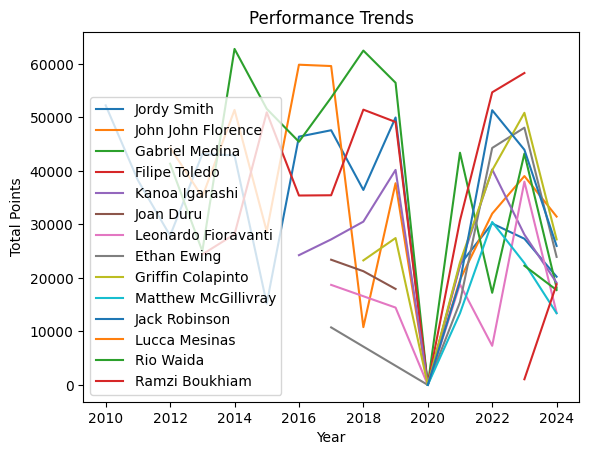

In [14]:
import matplotlib.pyplot as plt

for name in df['Name'].unique():
    athlete_data = df[df['Name'] == name]
    plt.plot(athlete_data['Year'], athlete_data['Total Points'], label=name)

plt.xlabel('Year')
plt.ylabel('Total Points')
plt.title('Performance Trends')
plt.legend()
plt.show()

# df['Experience'] = df.groupby('Name').cumcount() + 1


In [11]:
df.loc[df['SHISEIDO Tahiti Pro presented by Outerknown'] > 0, 'Total Points'] += df['SHISEIDO Tahiti Pro presented by Outerknown']
df.loc[df['SHISEIDO Tahiti Pro'] > 0, 'Total Points'] += df['SHISEIDO Tahiti Pro']*0.5
print(df.loc[df['Year'] == 2024])

    Rank                 Name  Total Points  Year Quiksilver Pro Gold Coast  \
504    1   John John Florence       39265.0  2024                       NaN   
505    2    Griffin Colapinto       28525.0  2024                       NaN   
506    3        Jack Robinson       27310.0  2024                       NaN   
507    4          Ethan Ewing       27250.0  2024                       NaN   
509    6          Jordy Smith       23545.0  2024                       NaN   
513   10       Kanoa Igarashi       22410.0  2024                       NaN   
514   11       Ramzi Boukhiam       24885.0  2024                       NaN   
515   12       Gabriel Medina       24235.0  2024                       NaN   
516   13            Rio Waida       22480.0  2024                       NaN   
523   20  Leonardo Fioravanti       14810.0  2024                       NaN   
524   21  Matthew McGillivray       14725.0  2024                       NaN   

    Rip Curl Pro Bells Beach Santa Catarina Pro Bil

In [12]:
df.loc[df['Year'] == 2024, 'Total Points'] *= 2
df.loc[df['Year'] == 2023, 'Total Points'] *= 1.5

In [287]:
import requests
from bs4 import BeautifulSoup

opening_round_url = 'https://www.worldsurfleague.com/events/2024/ct/201/shiseido-tahiti-pro/results?roundId=23691'

response = requests.get(opening_round_url)
html_content = response.content


with open('opening_round.html', 'wb') as file:
    file.write(html_content)

print("HTML content saved for analysis.")

HTML content saved for analysis.


In [288]:

with open('opening_round.html', 'r', encoding='utf-8') as file:
    html_content = file.read()


soup = BeautifulSoup(html_content, 'html.parser')


print(soup.prettify())

<!DOCTYPE html>
<!--[if lt IE 7 ]><html lang="en" class="ie ie6 lte10 lte9 lte8 lte7 page-type--not-index page-type--joint-events page-sub-type--joint-event-results"><![endif]-->
<!--[if IE 7 ]><html lang="en" class="ie ie7 lte10 lte9 lte8 lte7 gt6 page-type--not-index page-type--joint-events page-sub-type--joint-event-results"><![endif]-->
<!--[if IE 8 ]><html lang="en" class="ie ie8 lte10 lte9 lte8 gt6 gt7 page-type--not-index page-type--joint-events page-sub-type--joint-event-results"><![endif]-->
<!--[if IE 9 ]><html lang="en" class="ie ie9 lte10 lte9 gt6 gt7 gt8 page-type--not-index page-type--joint-events page-sub-type--joint-event-results"><![endif]-->
<!--[if (gt IE 9)|!(IE)]><!-->
<html class="page-type--not-index page-type--joint-events page-sub-type--joint-event-results" lang="en">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=5.0" name="viewport"/>
  <title>
   Results - SHISEIDO Tahiti Pro 2024 | W

In [291]:
def extract_opening_round_data(soup):
    heats = soup.find_all('div', class_='post-event-watch-heat-grid__heat')
    data = []

    for heat in heats:
        heat_number = heat.find('span', class_='heat-name').text.strip()
        surfers = heat.find_all('div', class_='hot-heat-athlete')

        for surfer in surfers:
            name_div = surfer.find('div', class_='avatar-text-primary')
            if name_div:
                name_elements = name_div.text.strip().split()
                if len(name_elements) > 1:
                    # name = name_elements[2] + " " + name_elements[1]  # get the second element
                    name = ""
                    for i in range(2,len(name_elements)):
                        if(i == len(name_elements)-2):
                            name+= name_elements[i]
                            break
                        name += name_elements[i] + " "

                    # name = name_elements
                else:
                    name = "Unknown"
            else:
                name = "Unknown"
            country_div = surfer.find('span', class_='athlete-country-flag')
            country = country_div['title'] if country_div else "Unknown"
            data.append({'Heat': heat_number, 'Name': name, 'Country': country})

    return pd.DataFrame(data)

opening_round_data = extract_opening_round_data(soup)
print(opening_round_data)

      Heat                 Name           Country
0   Heat 1          Ethan Ewing         Australia
1   Heat 1           Seth Moniz            Hawaii
2   Heat 1       Connor O'Leary             Japan
3   Heat 2   John John Florence            Hawaii
4   Heat 2            Rio Waida         Indonesia
5   Heat 2            Yago Dora            Brazil
6   Heat 3        Jack Robinson         Australia
7   Heat 3       Ramzi Boukhiam           Morocco
8   Heat 3         Kelly Slater     United States
9   Heat 4    Griffin Colapinto     United States
10  Heat 4       Italo Ferreira            Brazil
11  Heat 4       Mihimana Braye  French Polynesia
12  Heat 5          Jordy Smith      South Africa
13  Heat 5     Crosby Colapinto     United States
14  Heat 5  Matthew McGillivray      South Africa
15  Heat 6        Jake Marshall     United States
16  Heat 6   Imaikalani deVault            Hawaii
17  Heat 6       Gabriel Medina            Brazil
18  Heat 7        Barron Mamiya            Hawaii


## Process


### Extraccion de datos


Los cruces fueron extraidos de la pagina oficial de las siguientes imagenes:

https://isasurf.org/wp-content/themes/isa/images/women_1.svg

https://isasurf.org/wp-content/themes/isa/images/men_1.svg

In [111]:
import pandas as pd

dataframe = {'Heat':['HEAT1','HEAT1','HEAT1','HEAT2','HEAT2','HEAT2','HEAT3','HEAT3','HEAT3','HEAT4','HEAT4','HEAT4','HEAT5','HEAT5','HEAT5','HEAT6','HEAT6','HEAT6','HEAT7','HEAT7','HEAT7','HEAT8','HEAT8','HEAT8'],
             'Name':['Ethan Ewing','Tim Elter','Jordy Smith','Joan Duru' ,'Jack Robinson','Matthew McCilliuray','Alonso Correa','Filipe Toledo',
                     'Kanoa lgarashi','Cabriel Medina','Connor OLeary','Bryan Perez','Ramzi Boukhiam','Billy Stairmand','João Chianca',
                     'Andy Criere','John John Florence','Alan Cleland','Kauli Uaast','Lucca Mesinas','Criffin Colapinto','Rio Waida','LeonardoFiorauanti',
                     'Reo Inaba']
             }

heats = pd.DataFrame(dataframe)
print(heats)

     Heat                 Name
0   HEAT1          Ethan Ewing
1   HEAT1            Tim Elter
2   HEAT1          Jordy Smith
3   HEAT2            Joan Duru
4   HEAT2        Jack Robinson
5   HEAT2  Matthew McCilliuray
6   HEAT3        Alonso Correa
7   HEAT3        Filipe Toledo
8   HEAT3       Kanoa lgarashi
9   HEAT4       Cabriel Medina
10  HEAT4        Connor OLeary
11  HEAT4          Bryan Perez
12  HEAT5       Ramzi Boukhiam
13  HEAT5      Billy Stairmand
14  HEAT5         João Chianca
15  HEAT6          Andy Criere
16  HEAT6   John John Florence
17  HEAT6         Alan Cleland
18  HEAT7          Kauli Uaast
19  HEAT7        Lucca Mesinas
20  HEAT7    Criffin Colapinto
21  HEAT8            Rio Waida
22  HEAT8   LeonardoFiorauanti
23  HEAT8            Reo Inaba


Obteniendo los urls del perfil oficial de cada atleta

In [113]:
nums = [4133,13157,564,621,3442,3737,1551,1456,3896,1085,2838,10252,1349,2038,9167,2649,199,9341,8990,4391,3165,9112,2656,1490]
heats['url'] = nums
print(heats)

     Heat                 Name    url
0   HEAT1          Ethan Ewing   4133
1   HEAT1            Tim Elter  13157
2   HEAT1          Jordy Smith    564
3   HEAT2            Joan Duru    621
4   HEAT2        Jack Robinson   3442
5   HEAT2  Matthew McCilliuray   3737
6   HEAT3        Alonso Correa   1551
7   HEAT3        Filipe Toledo   1456
8   HEAT3       Kanoa lgarashi   3896
9   HEAT4       Cabriel Medina   1085
10  HEAT4        Connor OLeary   2838
11  HEAT4          Bryan Perez  10252
12  HEAT5       Ramzi Boukhiam   1349
13  HEAT5      Billy Stairmand   2038
14  HEAT5         João Chianca   9167
15  HEAT6          Andy Criere   2649
16  HEAT6   John John Florence    199
17  HEAT6         Alan Cleland   9341
18  HEAT7          Kauli Uaast   8990
19  HEAT7        Lucca Mesinas   4391
20  HEAT7    Criffin Colapinto   3165
21  HEAT8            Rio Waida   9112
22  HEAT8   LeonardoFiorauanti   2656
23  HEAT8            Reo Inaba   1490


In [126]:
urls = []

for name in heats.iterrows():
  nombre = name[1].iloc[1]
  if nombre == 'LeonardoFiorauanti':
    nombre = 'Leonardo Fiorauanti'
  elif nombre == 'João Chianca':
    nombre = 'Joao Chianca'
  norm_name= nombre.replace(' ', '-').lower()
  url = f'https://www.worldsurfleague.com/athletes/{name[1].iloc[2]}/{norm_name}?isearch=true&scategory=all'
  urls.append(url)
print(urls)


['https://www.worldsurfleague.com/athletes/4133/ethan-ewing?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/13157/tim-elter?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/564/jordy-smith?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/621/joan-duru?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/3442/jack-robinson?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/3737/matthew-mccilliuray?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/1551/alonso-correa?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/1456/filipe-toledo?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/3896/kanoa-lgarashi?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/1085/cabriel-medina?isearch=true&scategory=all', 'https://www.worldsurfleague.com/athletes/2838/connor-oleary?isearch=true&scategory=all', 'https://www.w

In [128]:
def get_stats (url, name, heat, filas):
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')

  table = soup.find_all('div', class_='new-athlete-stats__body')

  headers = table[1].find_all('th')

  columns =['Heat','Name']
  columns.append(headers[0].find('span').get_text(strip=True))

  columns.append('Average Points per Events')

  rows = table[1].find_all('tr')

  count=0;

  for row in rows:
    if not count:
      count=1
      continue
    celd = [heat, name]
    celdas = row.find_all('td')

    if(celdas[2].get_text(strip=True) == '-'):
      continue

    celd.append(celdas[0].get_text(strip=True))



    points = float(celdas[2].get_text(strip=True).replace(',',''))

    events = float(celdas[3].get_text(strip=True).replace(',',''))

    prom = points/events
    celd.append(prom)

    filas.append(celd)




  return filas, columns


In [129]:
filas = []
columns = []

for i,url in enumerate(urls):

  temp = get_stats(url, heats['Name'][i], heats['Heat'][i], filas)
  columns = temp[1]
  filas = temp[0]



df2 = pd.DataFrame(filas, columns=columns)


print(df2)

      Heat         Name  Year  Average Points per Events
0    HEAT1  Ethan Ewing  2024                3988.333333
1    HEAT1  Ethan Ewing  2023                4370.909091
2    HEAT1  Ethan Ewing  2022                4026.363636
3    HEAT1  Ethan Ewing  2021                2210.000000
4    HEAT1  Ethan Ewing  2017                 977.272727
..     ...          ...   ...                        ...
193  HEAT8    Reo Inaba  2016                 261.428571
194  HEAT8    Reo Inaba  2015                 139.333333
195  HEAT8    Reo Inaba  2014                 125.800000
196  HEAT8    Reo Inaba  2013                 141.400000
197  HEAT8    Reo Inaba  2012                 115.750000

[198 rows x 4 columns]


In [130]:
df2.to_csv('heats.csv', index=False)

In [217]:
# import numpy as np
from sklearn.neighbors import KernelDensity

df_unique = df2.drop_duplicates(subset='Name', keep='first')

kdes=[]


for name in df_unique['Name']:
  points = df2.loc[df2['Name'] == name, 'Average Points per Events']
  dataset = points.values[:, np.newaxis]
  kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(dataset)

  kdes.append([name,kde,dataset])


In [264]:
def simulate_tournament(kdes):

  oficial_results=[]

  for i in range(8):
    heat_result=[]
    name_result=[]
    a=i*3

    for _ in range(1000):
      simulations = []
      for j in range(3):
        simulated_points = []
        while True:
          simulated_points = kdes[a+j][1].sample(1).flatten()
          if simulated_points[0] > 0:
            break
        simulations.append((kdes[a+j][0],simulated_points[0]))
        heat_result.append((kdes[a+j][0],simulated_points[0]))

      simulations.sort(key=lambda x: x[1], reverse=True)

      name_result.append([sim[0] for sim in simulations])



    heat_result.sort(key=lambda x: x[1], reverse=True)

    name_results = pd.DataFrame(name_result, columns=['1st', '2nd', '3rd'])

    top_3_names = name_results.apply(pd.Series.value_counts).fillna(0).reset_index()

    top_3_names.columns = ['Name', '1st', '2nd', '3rd']

    top_3_names = top_3_names.sort_values(by='1st', ascending=False)

    count = 0
    heats = []

    for i in top_3_names['Name']:
      for item in heat_result:
        if(item[0] == i):
          heats.append(item[1])
          break

    top_3_names['Heats'] = heats
    oficial_results.append(top_3_names)

  return oficial_results





oficial_results = simulate_tournament(kdes)
print(oficial_results)

[          Name    1st    2nd     3rd        Heats
1  Jordy Smith  626.0  374.0     0.0  5225.912971
0  Ethan Ewing  374.0  626.0     0.0  4372.163160
2    Tim Elter    0.0    0.0  1000.0   168.812625,                   Name  1st  2nd  3rd        Heats
0        Jack Robinson  599   94  307  4668.991505
2  Matthew McCilliuray  299  451  250  3046.018614
1            Joan Duru  102  455  443  2135.555106,              Name    1st  2nd    3rd        Heats
1   Filipe Toledo  775.0  181   44.0  5301.168642
2  Kanoa lgarashi  225.0  775    0.0  3661.991539
0   Alonso Correa    0.0   44  956.0  2044.685764,              Name    1st    2nd     3rd        Heats
1  Cabriel Medina  930.0   70.0     0.0  5741.191227
2   Connor OLeary   70.0  930.0     0.0  3351.925026
0     Bryan Perez    0.0    0.0  1000.0   353.031827,               Name  1st  2nd  3rd        Heats
1     João Chianca  467  242  291  4027.636019
2   Ramzi Boukhiam  330  249  421  3134.678152
0  Billy Stairmand  203  509  288  304

simulando round 2

actualizando kde

In [265]:
kdes_round_2 = []

for heat in oficial_results:
  count=0


  for i,name in heat.iterrows():
    if count==0:
      count= 1
      continue

    nombre = name.iloc[0]
    puntuacion = (pd.Series(name.iloc[4])).values[:, np.newaxis]


    for x in kdes:
      if nombre == x[0]:
        datas = np.concatenate((x[2],puntuacion), axis=0)
        kde = KernelDensity(kernel='gaussian', bandwidth=1000).fit(datas)
        x[1] = kde
        x[2] = datas
        kdes_round_2.append(x)
        break


In [266]:
import random

random.shuffle(kdes_round_2)

pairs = [(kdes_round_2[i], kdes_round_2[i+1]) for i in range(0, len(kdes_round_2), 2)]

print(pairs)

[(['Ramzi Boukhiam', KernelDensity(bandwidth=1000), array([[3133.33333333],
       [ 212.        ],
       [3134.67815211]])], ['Matthew McCilliuray', KernelDensity(bandwidth=1000), array([[2232.5       ],
       [2278.        ],
       [3045.        ],
       [1913.57142857],
       [ 420.        ],
       [3046.01861445]])]), (['Tim Elter', KernelDensity(bandwidth=1000), array([[115.       ],
       [ 93.       ],
       [167.5      ],
       [150.       ],
       [ 90.       ],
       [100.       ],
       [168.8126246]])], ['Kanoa lgarashi', KernelDensity(bandwidth=1000), array([[3181.66666667],
       [2810.        ],
       [3660.90909091],
       [3173.57142857],
       [3653.18181818],
       [2774.54545455],
       [2472.72727273],
       [2204.54545455],
       [3661.991539  ]])]), (['Reo Inaba', KernelDensity(bandwidth=1000), array([[1072.66666667],
       [ 400.        ],
       [1000.        ],
       [1500.        ],
       [ 814.        ],
       [ 443.57142857],
       

In [269]:
def simulate_round_2(kdes):

  oficial_results=[]

  for i in range(8):
    heat_result=[]
    name_result=[]
    # a=i*2

    for _ in range(1000):
      simulations = []
      for j in range(2):
        simulated_points = []
        while True:
          simulated_points = kdes[i][j][1].sample(1).flatten()
          if simulated_points[0] > 0:
            break
        simulations.append((kdes[i][j][0],simulated_points[0]))
        heat_result.append((kdes[i][j][0],simulated_points[0]))

      simulations.sort(key=lambda x: x[1], reverse=True)
      name_result.append([sim[0] for sim in simulations])



    heat_result.sort(key=lambda x: x[1], reverse=True)

    name_results = pd.DataFrame(name_result, columns=['1st', '2nd'])

    top_by_heat = name_results.apply(pd.Series.value_counts).fillna(0).reset_index()

    top_by_heat.columns = ['Name', '1st', '2nd']

    top_by_heat = top_by_heat.sort_values(by='1st', ascending=False)

    count = 0
    heats = []


    for i in top_by_heat['Name']:
      for item in heat_result:
        if(item[0] == i):
          heats.append(item[1])
          break


    top_by_heat['Heats'] = heats
    oficial_results.append(top_by_heat)

  return oficial_results





round_2_results = simulate_round_2(pairs)

In [270]:
print(round_2_results)

[                  Name  1st  2nd        Heats
1       Ramzi Boukhiam  579  421  5800.041608
0  Matthew McCilliuray  421  579  6027.835638,              Name  1st  2nd        Heats
0  Kanoa lgarashi  967   33  6364.960132
1       Tim Elter   33  967  3476.252749,         Name  1st  2nd        Heats
0  Joan Duru  767  233  6020.613394
1  Reo Inaba  233  767  3922.364172,             Name  1st  2nd        Heats
1  Connor OLeary  828  172  6337.961142
0  Alonso Correa  172  828  4966.933203,                  Name  1st  2nd        Heats
1  LeonardoFiorauanti  891  109  6383.199558
0         Bryan Perez  109  891  3567.648253,               Name  1st  2nd        Heats
1  Billy Stairmand  566  434  5970.171264
0     Alan Cleland  434  566  4465.105227,           Name  1st  2nd        Heats
1  Kauli Uaast  597  403  5229.638220
0  Andy Criere  403  597  4939.710161,             Name  1st  2nd        Heats
0    Ethan Ewing  809  191  7699.756578
1  Lucca Mesinas  191  809  6140.981632]


In [271]:
kdes_round_3 = []


for heat in round_2_results:
  for i in heat.iterrows():
    nombre = i[1].iloc[0]
    for k in kdes_round_2:
      if k[0] == nombre:
        kdes_round_3.append(k)
        break
    break

for heat in oficial_results:
  count=0
  for i,name in heat.iterrows():
    if count==1:
      count=0
      break
    count= 1

    nombre =name.iloc[0]
    puntuacion = (pd.Series(name.iloc[4])).values[:, np.newaxis]

    for x in kdes:
      if nombre == x[0]:
        datas = np.concatenate((x[2],puntuacion), axis=0)
        kde = KernelDensity(kernel='gaussian', bandwidth=1000).fit(datas)
        x[1] = kde
        x[2] = datas
        kdes_round_3.append(x)
        break



random.shuffle(kdes_round_3)
pairs = [(kdes_round_3[i], kdes_round_3[i+1]) for i in range(0, len(kdes_round_3), 2)]
print(pairs)


[(['Rio Waida', KernelDensity(bandwidth=1000), array([[2955.83333333],
       [2228.        ],
       [3320.        ],
       [1330.        ],
       [3321.53866517]])], ['Criffin Colapinto', KernelDensity(bandwidth=1000), array([[4532.5       ],
       [4623.63636364],
       [4012.        ],
       [3272.14285714],
       [2745.        ],
       [2115.90909091],
       [4624.94632444]])]), (['Kauli Uaast', KernelDensity(bandwidth=1000), array([[1105.75      ],
       [1273.        ],
       [ 687.        ],
       [2216.66666667],
       [ 560.16666667],
       [ 337.77777778],
       [ 382.5       ],
       [2218.15168342]])], ['Cabriel Medina', KernelDensity(bandwidth=1000), array([[3025.        ],
       [4324.        ],
       [5740.        ],
       [5425.        ],
       [5134.09090909],
       [5680.90909091],
       [4881.81818182],
       [4131.81818182],
       [4690.90909091],
       [5709.09090909],
       [2500.        ],
       [4135.        ],
       [4783.33333333],


Simulando ronda 3

In [272]:
def simulate_round_3(kdes):

  oficial_results=[]

  for i in range(8):
    heat_result=[]
    name_result=[]

    for _ in range(1000):
      simulations = []
      for j in range(2):
        simulated_points = []
        while True:
          simulated_points = kdes[i][j][1].sample(1).flatten()
          if simulated_points[0] > 0:
            break
        simulations.append((kdes[i][j][0],simulated_points[0]))
        heat_result.append((kdes[i][j][0],simulated_points[0]))

      simulations.sort(key=lambda x: x[1], reverse=True)
      name_result.append([sim[0] for sim in simulations])



    heat_result.sort(key=lambda x: x[1], reverse=True)

    name_results = pd.DataFrame(name_result, columns=['1st', '2nd'])

    top_by_heat = name_results.apply(pd.Series.value_counts).fillna(0).reset_index()

    top_by_heat.columns = ['Name', '1st', '2nd']

    top_by_heat = top_by_heat.sort_values(by='1st', ascending=False)


    heats = []


    for i in top_by_heat['Name']:
      for item in heat_result:
        if(item[0] == i):
          heats.append(item[1])
          break


    top_by_heat['Heats'] = heats
    oficial_results.append(top_by_heat)

  return oficial_results





round_3_results = simulate_round_3(pairs)
print(round_3_results)

[                Name  1st  2nd        Heats
0  Criffin Colapinto  711  289  7779.626333
1          Rio Waida  289  711  6028.947976,              Name  1st  2nd       Heats
0  Cabriel Medina  944   56  8780.96298
1     Kauli Uaast   56  944  5863.34326,              Name  1st  2nd        Heats
0     Jordy Smith  750  250  7878.814145
1  Ramzi Boukhiam  250  750  7035.478344,           Name  1st  2nd        Heats
0  Ethan Ewing  778  222  7387.030602
1    Joan Duru  222  778  4989.647746,             Name  1st  2nd        Heats
1  Filipe Toledo  767  233  7877.126053
0  Connor OLeary  233  767  6231.786101,              Name  1st  2nd        Heats
0   Jack Robinson  541  459  7947.999110
1  Kanoa lgarashi  459  541  6230.691734,                  Name  1st  2nd        Heats
0        João Chianca  572  428  6916.021126
1  LeonardoFiorauanti  428  572  6665.591834,                  Name  1st  2nd        Heats
1  John John Florence  929   71  8834.373168
0     Billy Stairmand   71  929  59

In [273]:
kdes_quarter_finals = []

for heat in round_3_results:
  for i in heat.iterrows():
    nombre = i[1].iloc[0]
    puntuacion = (pd.Series(i[1].iloc[3])).values[:, np.newaxis]
    for x in kdes:
      if nombre == x[0]:
        datas = np.concatenate((x[2],puntuacion), axis=0)
        kde = KernelDensity(kernel='gaussian', bandwidth=1000).fit(datas)
        x[1] = kde
        x[2] = datas
        kdes_quarter_finals.append(x)
        break
    break


pairs = [(kdes_quarter_finals[i], kdes_quarter_finals[i+1]) for i in range(0, len(kdes_quarter_finals), 2)]
print(pairs)


[(['Criffin Colapinto', KernelDensity(bandwidth=1000), array([[4532.5       ],
       [4623.63636364],
       [4012.        ],
       [3272.14285714],
       [2745.        ],
       [2115.90909091],
       [4624.94632444],
       [7779.62633288]])], ['Cabriel Medina', KernelDensity(bandwidth=1000), array([[3025.        ],
       [4324.        ],
       [5740.        ],
       [5425.        ],
       [5134.09090909],
       [5680.90909091],
       [4881.81818182],
       [4131.81818182],
       [4690.90909091],
       [5709.09090909],
       [2500.        ],
       [4135.        ],
       [4783.33333333],
       [5741.19122732],
       [8780.96298046]])]), (['Jordy Smith', KernelDensity(bandwidth=1000), array([[3370.83333333],
       [2732.5       ],
       [3017.5       ],
       [4501.        ],
       [4544.09090909],
       [3312.72727273],
       [4327.27272727],
       [4218.18181818],
       [2533.33333333],
       [3900.        ],
       [4794.44444444],
       [2790.        ],


simulando cuartos

In [275]:
def simulate_quarter(kdes):

  oficial_results=[]

  for i in range(4):
    heat_result=[]
    name_result=[]

    for _ in range(1000):
      simulations = []
      for j in range(2):
        simulated_points = []
        while True:
          simulated_points = kdes[i][j][1].sample(1).flatten()
          if simulated_points[0] > 0:
            break
        simulations.append((kdes[i][j][0],simulated_points[0]))
        heat_result.append((kdes[i][j][0],simulated_points[0]))

      simulations.sort(key=lambda x: x[1], reverse=True)
      name_result.append([sim[0] for sim in simulations])



    heat_result.sort(key=lambda x: x[1], reverse=True)

    name_results = pd.DataFrame(name_result, columns=['1st', '2nd'])

    top_by_heat = name_results.apply(pd.Series.value_counts).fillna(0).reset_index()

    top_by_heat.columns = ['Name', '1st', '2nd']

    top_by_heat = top_by_heat.sort_values(by='1st', ascending=False)


    heats = []


    for i in top_by_heat['Name']:
      for item in heat_result:
        if(item[0] == i):
          heats.append(item[1])
          break


    top_by_heat['Heats'] = heats
    oficial_results.append(top_by_heat)

  return oficial_results

quarter_results = simulate_quarter(pairs)
print(quarter_results)

[                Name  1st  2nd         Heats
0     Cabriel Medina  617  383  11462.382834
1  Criffin Colapinto  383  617  10373.735141,           Name  1st  2nd         Heats
1  Jordy Smith  502  498  10787.665966
0  Ethan Ewing  498  502  10150.359657,             Name  1st  2nd         Heats
0  Filipe Toledo  592  408   9722.103472
1  Jack Robinson  408  592  10814.215247,                  Name  1st  2nd         Heats
0  John John Florence  649  351  10699.077406
1        João Chianca  351  649   9000.882787]


In [276]:
kdes_semi_finals = []

for heat in quarter_results:
  for i in heat.iterrows():
    nombre = i[1].iloc[0]
    puntuacion = (pd.Series(i[1].iloc[3])).values[:, np.newaxis]
    for x in kdes:
      if nombre == x[0]:
        datas = np.concatenate((x[2],puntuacion), axis=0)
        kde = KernelDensity(kernel='gaussian', bandwidth=1000).fit(datas)
        x[1] = kde
        x[2] = datas
        kdes_semi_finals.append(x)
        break
    break

pairs = [(kdes_semi_finals[i], kdes_semi_finals[i+1]) for i in range(0, len(kdes_semi_finals), 2)]
print(pairs)


[(['Cabriel Medina', KernelDensity(bandwidth=1000), array([[ 3025.        ],
       [ 4324.        ],
       [ 5740.        ],
       [ 5425.        ],
       [ 5134.09090909],
       [ 5680.90909091],
       [ 4881.81818182],
       [ 4131.81818182],
       [ 4690.90909091],
       [ 5709.09090909],
       [ 2500.        ],
       [ 4135.        ],
       [ 4783.33333333],
       [ 5741.19122732],
       [ 8780.96298046],
       [11462.38283427]])], ['Jordy Smith', KernelDensity(bandwidth=1000), array([[ 3370.83333333],
       [ 2732.5       ],
       [ 3017.5       ],
       [ 4501.        ],
       [ 4544.09090909],
       [ 3312.72727273],
       [ 4327.27272727],
       [ 4218.18181818],
       [ 2533.33333333],
       [ 3900.        ],
       [ 4794.44444444],
       [ 2790.        ],
       [ 4250.        ],
       [ 5225.        ],
       [ 5225.91297077],
       [ 7878.81414549],
       [10787.6659657 ]])]), (['Filipe Toledo', KernelDensity(bandwidth=1000), array([[ 265.      

In [277]:
def simulate_semis(kdes):

  oficial_results=[]

  for i in range(2):
    heat_result=[]
    name_result=[]

    for _ in range(1000):
      simulations = []
      for j in range(2):
        simulated_points = []
        while True:
          simulated_points = kdes[i][j][1].sample(1).flatten()
          if simulated_points[0] > 0:
            break
        simulations.append((kdes[i][j][0],simulated_points[0]))
        heat_result.append((kdes[i][j][0],simulated_points[0]))

      simulations.sort(key=lambda x: x[1], reverse=True)
      name_result.append([sim[0] for sim in simulations])



    heat_result.sort(key=lambda x: x[1], reverse=True)

    name_results = pd.DataFrame(name_result, columns=['1st', '2nd'])

    top_by_heat = name_results.apply(pd.Series.value_counts).fillna(0).reset_index()

    top_by_heat.columns = ['Name', '1st', '2nd']

    top_by_heat = top_by_heat.sort_values(by='1st', ascending=False)


    heats = []


    for i in top_by_heat['Name']:
      for item in heat_result:
        if(item[0] == i):
          heats.append(item[1])
          break


    top_by_heat['Heats'] = heats
    oficial_results.append(top_by_heat)

  return oficial_results



semis_results = simulate_semis(pairs)
print(semis_results)

[             Name  1st  2nd         Heats
0  Cabriel Medina  643  357  13635.875082
1     Jordy Smith  357  643  14040.380547,                  Name  1st  2nd         Heats
1  John John Florence  602  398  13082.455390
0       Filipe Toledo  398  602  11941.761578]


In [278]:
kdes_final = []

for heat in semis_results:
  for i in heat.iterrows():
    nombre = i[1].iloc[0]
    puntuacion = (pd.Series(i[1].iloc[3])).values[:, np.newaxis]

    for x in kdes:
      if nombre == x[0]:
        datas = np.concatenate((x[2],puntuacion), axis=0)
        kde = KernelDensity(kernel='gaussian', bandwidth=1000).fit(datas)
        x[1] = kde
        x[2] = datas
        kdes_final.append(x)
        break
    break


pairs = [(kdes_final[i], kdes_final[i+1]) for i in range(0, len(kdes_final), 2)]
print(pairs)


[(['Cabriel Medina', KernelDensity(bandwidth=1000), array([[ 3025.        ],
       [ 4324.        ],
       [ 5740.        ],
       [ 5425.        ],
       [ 5134.09090909],
       [ 5680.90909091],
       [ 4881.81818182],
       [ 4131.81818182],
       [ 4690.90909091],
       [ 5709.09090909],
       [ 2500.        ],
       [ 4135.        ],
       [ 4783.33333333],
       [ 5741.19122732],
       [ 8780.96298046],
       [11462.38283427],
       [13635.87508232]])], ['John John Florence', KernelDensity(bandwidth=1000), array([[ 5244.16666667],
       [ 3903.5       ],
       [ 5335.83333333],
       [ 4915.        ],
       [ 6283.33333333],
       [ 2159.        ],
       [ 5418.18181818],
       [ 5440.90909091],
       [ 3188.88888889],
       [ 4672.72727273],
       [ 4393.75      ],
       [ 4435.        ],
       [ 2390.        ],
       [ 6284.46045024],
       [ 8834.37316786],
       [10699.07740644],
       [13082.45539019]])])]


In [279]:
kdes_3rd = []

for heat in semis_results:
  count = 1
  for i in heat.iterrows():
    if count:
      count = 0
      continue
    nombre = i[1].iloc[0]

    puntuacion = (pd.Series(i[1].iloc[3])).values[:, np.newaxis]
    for x in kdes:
      if nombre == x[0]:
        datas = np.concatenate((x[2],puntuacion), axis=0)
        kde = KernelDensity(kernel='gaussian', bandwidth=1000).fit(datas)
        x[1] = kde
        x[2] = datas
        kdes_3rd.append(x)
        break




pairs3 = [(kdes_3rd[i], kdes_3rd[i+1]) for i in range(0, len(kdes_3rd), 2)]
print(pairs3)

[(['Jordy Smith', KernelDensity(bandwidth=1000), array([[ 3370.83333333],
       [ 2732.5       ],
       [ 3017.5       ],
       [ 4501.        ],
       [ 4544.09090909],
       [ 3312.72727273],
       [ 4327.27272727],
       [ 4218.18181818],
       [ 2533.33333333],
       [ 3900.        ],
       [ 4794.44444444],
       [ 2790.        ],
       [ 4250.        ],
       [ 5225.        ],
       [ 5225.91297077],
       [ 7878.81414549],
       [10787.6659657 ],
       [14040.38054725]])], ['Filipe Toledo', KernelDensity(bandwidth=1000), array([[  265.        ],
       [ 5300.        ],
       [ 4971.81818182],
       [ 3841.875     ],
       [ 4467.72727273],
       [ 4677.27272727],
       [ 3545.        ],
       [ 3933.33333333],
       [ 4631.81818182],
       [ 2815.        ],
       [ 2440.        ],
       [ 5301.1686416 ],
       [ 7877.12605261],
       [ 9722.10347234],
       [11941.76157758]])])]


In [280]:
def simulate_3rd(kdes):

  oficial_results=[]

  for i in range(1):
    heat_result=[]
    name_result=[]

    for _ in range(1000):
      simulations = []
      for j in range(2):
        simulated_points = []
        while True:
          simulated_points = kdes[i][j][1].sample(1).flatten()
          if simulated_points[0] > 0:
            break
        simulations.append((kdes[i][j][0],simulated_points[0]))
        heat_result.append((kdes[i][j][0],simulated_points[0]))

      simulations.sort(key=lambda x: x[1], reverse=True)
      name_result.append([sim[0] for sim in simulations])



    heat_result.sort(key=lambda x: x[1], reverse=True)

    name_results = pd.DataFrame(name_result, columns=['1st', '2nd'])

    top_by_heat = name_results.apply(pd.Series.value_counts).fillna(0).reset_index()

    top_by_heat.columns = ['Name', '1st', '2nd']

    top_by_heat = top_by_heat.sort_values(by='1st', ascending=False)

    heats = []


    for i in top_by_heat['Name']:
      for item in heat_result:
        if(item[0] == i):
          heats.append(item[1])
          break


    top_by_heat['Heats'] = heats
    oficial_results.append(top_by_heat)

  return oficial_results





final_results = simulate_3rd(pairs3)
print(f'The 3rd place is {final_results[0]['Name'][0]}')

The 3rd place is Filipe Toledo


In [281]:
def simulate_final(kdes):

  oficial_results=[]

  for i in range(1):
    heat_result=[]
    name_result=[]

    for _ in range(1000):
      simulations = []
      for j in range(2):
        simulated_points = []
        while True:
          simulated_points = kdes[i][j][1].sample(1).flatten()
          if simulated_points[0] > 0:
            break
        simulations.append((kdes[i][j][0],simulated_points[0]))
        heat_result.append((kdes[i][j][0],simulated_points[0]))

      simulations.sort(key=lambda x: x[1], reverse=True)
      name_result.append([sim[0] for sim in simulations])



    heat_result.sort(key=lambda x: x[1], reverse=True)

    name_results = pd.DataFrame(name_result, columns=['1st', '2nd'])

    top_by_heat = name_results.apply(pd.Series.value_counts).fillna(0).reset_index()

    top_by_heat.columns = ['Name', '1st', '2nd']

    top_by_heat = top_by_heat.sort_values(by='1st', ascending=False)


    heats = []


    for i in top_by_heat['Name']:
      for item in heat_result:
        if(item[0] == i):
          heats.append(item[1])
          break


    top_by_heat['Heats'] = heats
    oficial_results.append(top_by_heat)

  return oficial_results





final_results = simulate_final(pairs)
print(f'The winner is {final_results[0]['Name'][0]}')
print(f'The 2nd place is {final_results[0]['Name'][1]}')

The winner is Cabriel Medina
The 2nd place is John John Florence
